In [1]:
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()

In [12]:
#kindle_store = spark.read.json("hdfs:///user/cloudera/Kindle_Store_5_10.json")
df = spark.read.csv("/user/cloudera/NLPTEXT.csv",header=True)


In [14]:
df.columns
df.show()

+-----------+--------------------+----+----+----+----+----+
|      class|                text| _c2| _c3| _c4| _c5| _c6|
+-----------+--------------------+----+----+----+----+----+
|not_flagged|I try and avoid t...|null|null|null|null|null|
|    flagged|Had a friend open...|null|null|null|null|null|
|    flagged|I saved a girl fr...|null|null|null|null|null|
|not_flagged|i cant think of o...|null|null|null|null|null|
|not_flagged|"Only really one ...|    |null|null|null|null|
|not_flagged|a couple of years...|null|null|null|null|null|
|    flagged|Roommate when he ...|null|null|null|null|null|
|    flagged|i've had a couple...|null|null|null|null|null|
|not_flagged|Listened to someo...|null|null|null|null|null|
|    flagged|I will always lis...|null|null|null|null|null|
|not_flagged|Took a week off w...|null|null|null|null|null|
|    flagged|On the memorial a...|null|null|null|null|null|
|not_flagged|Anxious girlfrien...|null|null|null|null|null|
|not_flagged|               Never|null|n

In [19]:
# SELECTING IMPORTANT COLUMNS
df1 =df["text","class"]
df1.show()

+--------------------+-----------+
|                text|      class|
+--------------------+-----------+
|I try and avoid t...|not_flagged|
|Had a friend open...|    flagged|
|I saved a girl fr...|    flagged|
|i cant think of o...|not_flagged|
|"Only really one ...|not_flagged|
|a couple of years...|not_flagged|
|Roommate when he ...|    flagged|
|i've had a couple...|    flagged|
|Listened to someo...|not_flagged|
|I will always lis...|    flagged|
|Took a week off w...|not_flagged|
|On the memorial a...|    flagged|
|Anxious girlfrien...|not_flagged|
|               Never|not_flagged|
|        You as a mom|not_flagged|
|ex gf was a cutte...|    flagged|
|I have helped adv...|not_flagged|
|I've helped frien...|not_flagged|
|A friend that is ...|not_flagged|
|expressing concer...|not_flagged|
+--------------------+-----------+
only showing top 20 rows



# Data Preperation
# SQL through temporary table

In [20]:
# Create a temporary table from 'df1' DataFrame.
sqlContext.registerDataFrameAsTable(df1, "data")

In [21]:
# Show a list of tables recognized by spark.
spark.catalog.listTables()

[Table(name='categories', database='default', description='Imported by sqoop on 2020/02/17 09:58:54', tableType='MANAGED', isTemporary=False),
 Table(name='cust', database='default', description='Imported by sqoop on 2020/02/17 09:34:34', tableType='MANAGED', isTemporary=False),
 Table(name='customer_master', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='e2_customers', database='default', description='Imported by sqoop on 2020/03/19 15:38:48', tableType='MANAGED', isTemporary=False),
 Table(name='e2_orders', database='default', description='Imported by sqoop on 2020/03/19 16:18:22', tableType='MANAGED', isTemporary=False),
 Table(name='e2_payments', database='default', description='Imported by sqoop on 2020/03/19 16:11:15', tableType='MANAGED', isTemporary=False),
 Table(name='employees', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='order_items', database='default', description='Imported by sqo

In [22]:
# Show a list of tables recognized by spark using the SQL syntax.
# THESE TABLES ARE ALL ON HDFS NOW??????????????????????????????
spark.sql("SHOW TABLES").show()

+--------+------------------+-----------+
|database|         tableName|isTemporary|
+--------+------------------+-----------+
| default|        categories|      false|
| default|              cust|      false|
| default|   customer_master|      false|
| default|      e2_customers|      false|
| default|         e2_orders|      false|
| default|       e2_payments|      false|
| default|         employees|      false|
| default|       order_items|      false|
| default|          sessions|      false|
| default|       skype_users|      false|
| default|transaction_master|      false|
| default|      transactions|      false|
|        |              data|       true|
+--------+------------------+-----------+



In [56]:
# A query can be issued on the temporary table.
text1 = sqlContext.sql("SELECT * FROM data")

In [48]:
text1.show()
text1.describe()


+--------------------+-----------+
|                text|      class|
+--------------------+-----------+
|I try and avoid t...|not_flagged|
|Had a friend open...|    flagged|
|I saved a girl fr...|    flagged|
|i cant think of o...|not_flagged|
|"Only really one ...|not_flagged|
|a couple of years...|not_flagged|
|Roommate when he ...|    flagged|
|i've had a couple...|    flagged|
|Listened to someo...|not_flagged|
|I will always lis...|    flagged|
|Took a week off w...|not_flagged|
|On the memorial a...|    flagged|
|Anxious girlfrien...|not_flagged|
|               Never|not_flagged|
|        You as a mom|not_flagged|
|ex gf was a cutte...|    flagged|
|I have helped adv...|not_flagged|
|I've helped frien...|not_flagged|
|A friend that is ...|not_flagged|
|expressing concer...|not_flagged|
+--------------------+-----------+
only showing top 20 rows



DataFrame[summary: string, text: string, class: string]

In [57]:
text1.schema

StructType(List(StructField(text,StringType,true),StructField(class,StringType,true)))

# SENTIMENT ANALYSIS
Append sentiment as new column

In [38]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import col, udf

In [39]:
def calc_sentiment(text):
    s = TextBlob(text)
    return s.sentiment[0] # return polarity

#positive->1
#negative->0
def transform_star(star):
    if star >=3.0:
        return 1.0
    else:
        return 0.0

transformer = udf(calc_sentiment)

In [74]:
# Create a new column called 'text_sentiment' for sentiment scores on text.
df21 = text1.withColumn("title_sentiment",transformer(text1['text']))

In [75]:
df21.show()

Py4JJavaError: An error occurred while calling o633.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 35.0 failed 4 times, most recent failure: Lost task 0.3 in stage 35.0 (TID 62, quickstart.cloudera, executor 12): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/worker.py", line 168, in read_single_udf
    f, return_type = read_command(pickleSer, infile)
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/worker.py", line 69, in read_command
    command = serializer._read_with_length(file)
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/serializers.py", line 580, in loads
    return pickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'textblob'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1405)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3383)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2758)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.GeneratedMethodAccessor71.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/worker.py", line 366, in main
    func, profiler, deserializer, serializer = read_udfs(pickleSer, infile, eval_type)
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/worker.py", line 241, in read_udfs
    arg_offsets, udf = read_single_udf(pickleSer, infile, eval_type, runner_conf)
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/worker.py", line 168, in read_single_udf
    f, return_type = read_command(pickleSer, infile)
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/worker.py", line 69, in read_command
    command = serializer._read_with_length(file)
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/serializers.py", line 172, in _read_with_length
    return self.loads(obj)
  File "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2/python/pyspark/serializers.py", line 580, in loads
    return pickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'textblob'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1405)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


# Should look like this?

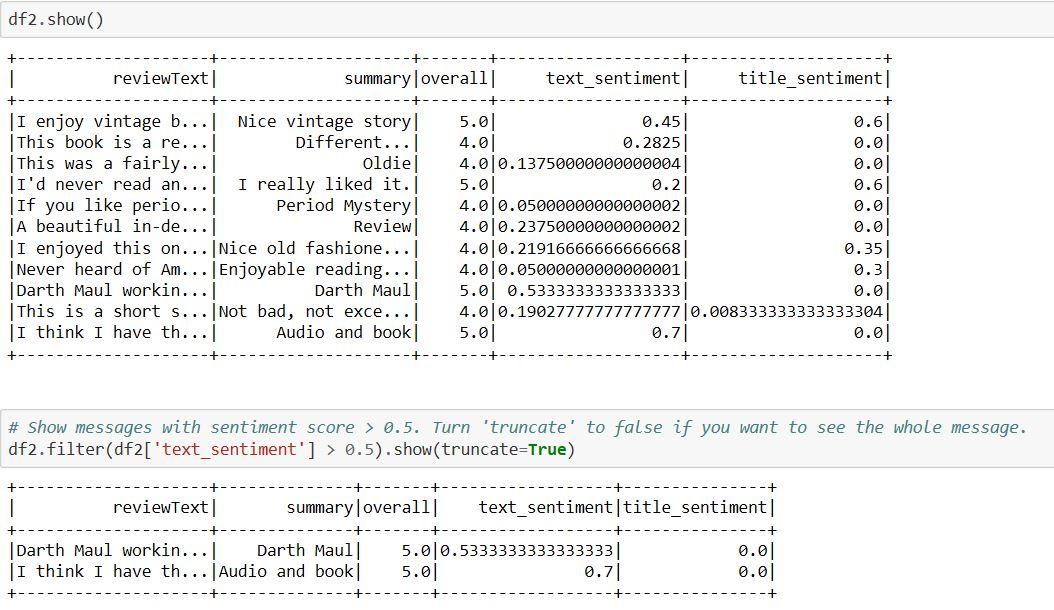

In [77]:
# Show messages with sentiment score > 0.5. Turn 'truncate' to false if you want to see the whole message.
df21.filter(df21['text_sentiment'] > 0.5).show(truncate=True)

AnalysisException: 'Cannot resolve column name "text_sentiment" among (text, class, title_sentiment);'